<a href="https://colab.research.google.com/github/k-gerasimova/numerical_methods-5-8/blob/main/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
from math import cos, sin, exp, sinh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
l = np.pi/4
a = 1

phi0 = lambda y,t: sinh(y) * exp(-3*a*t)
phi1 = lambda y,t: -2*sinh(y) * exp(-3*a*t)
phi2 = lambda x,t: cos(2*x) * exp(-3*a*t)
phi3 = lambda x,t: 3/4 * cos(2*x) * exp(-3*a*t)
psi = lambda x,y:  cos(2*x) * sinh(y)

U_true = lambda x,y,t: cos(2*x) * sinh(y) * exp(-3*a*t)

Nx = 50
Ny = 50
Nt = 20

x = np.linspace(0, l, Nx) #начало, конец, кол-во
y = np.linspace(0, math.log(2), Ny)
t = np.linspace(0, 1, Nt * 2)



In [ ]:
def find_true(x,y,t):
  U_true_m = np.zeros((len(t), len(y), len(x)))
  for k in range(len(t)):
    for j in range(len(y)):
      for i in range(len(x)):
        U_true_m[k,j,i] = U_true(x[i],y[j], t[k])
  return U_true_m

Метод переменных направлений

In [ ]:
def perem_naprav(x,y,t):
  hx = abs(x[1] - x[0])
  hy = abs(y[1] - y[0])
  ht = abs(t[1] - t[0])

  U = np.zeros((len(t), len(y), len(x)))

  #заполняем границы
  for k in range(len(t)):
    for j in range(len(y)):
      U[k,j,0] = phi0(y[j], t[k])
      U[k,j,-1] = 0
    for i in range(len(x)):
      U[k,-1,i]=phi3(x[i], t[k])
      U[k,0,i] =  0

  for j in range(len(y)):
    for i in range(len(x)):
      U[0,j,i] = psi(x[i], y[j])



#условие на крайнюю границу х, добавить в конец
#U[k,j,len(x)-1] = phi1(y[j], t[k])*hx  + U[k,j, len(x)-2]
#условие на начальную границу у, добавить в конец
#U[j,0,i] = U[j,1,i] - phi2(x[i], t[k])*hy

  koeffx = a*ht/hx**2   #ht - tau/2
  koeffy = a*ht/hy**2

  for k in range(0, len(t)-2, 2):
    #строим k+1/2 слой
    for j in range(1, len(y)-1):
      A = np.zeros((len(x)-2, len(x)-2))
      B = np.zeros((len(x)-2))
      A[0,0] = 1 + 2*koeffx
      A[0,1] = -koeffx
      B[0] = koeffy*(U[k,j+1,1] - 2*U[k,j,1] + U[k,j-1,1]) + koeffx*(U[k+1,j,0]) + U[k,j,1]
      A[-1,-1] = 1 + 2*koeffx
      A[-1,-2]=-koeffx
      B[-1]= koeffy*(U[k,j+1,-2] - 2*U[k,j,-2] + U[k,j-1,-2]) + koeffx*(U[k+1,j,-1]) + U[k,j,-2]

      for i in range(1, len(x)-3):
        A[i, i-1] = -koeffx
        A[i, i] = 1 + 2*koeffx
        A[i, i+1] = - koeffx
        B[i] = koeffy*(U[k,j+1,i+1] - 2*U[k,j,i+1] + U[k,j-1,i+1]) + U[k,j,i+1]
      U_vrem = np.linalg.solve(A, B)
      for i in range(1, len(x) -1):
        U[k + 1, j, i] = U_vrem[i-1]
      #считаем границу y по аппроксимации
   # for i in range(1, len(x)):
   #   U[k+1,0,i] = U[k+1,1,i] - phi2(x[i], t[k+1])*hy

    #k+1 шаг
    for i in range(1, len(x)-1):
      A = np.zeros((len(y) - 2, len(y) - 2))
      B = np.zeros((len(y) - 2))
      A[0, 0] = 1 + 2 * koeffy
      A[0, 1] = -koeffy
      B[0] = koeffx * (U[k+1, 1, i+1] - 2 * U[k+1, 1, i] + U[k+1,1,i-1]) + koeffy * (U[k+2,0,i]) + U[k+1,1,i]
      A[-1, -1] = 1 + 2 * koeffy
      A[-1, -2] = -koeffy
      B[-1] = koeffx * (U[k+1,-2, i+1] - 2 * U[k+1, -2, i] + U[k+1, -2, i-1]) + koeffy * (U[k+2,-1,i]) + U[k+1,-2,i]

      for j in range(1, len(y) - 3):
        A[j, j - 1] = -koeffy
        A[j, j] = 1 + 2 * koeffy
        A[j, j + 1] = - koeffy
        B[j] = koeffx * (U[k+1,j+1,i+1] - 2 * U[k+1,j+1,i] + U[k+1,j+1,i-1]) + U[k+1, j+1, i]
      U_vrem = np.linalg.solve(A, B)
      for j in range(1, len(y) - 1):
        U[k+2, j, i] = U_vrem[j - 1]
  return U



Метод дробных шагов

In [ ]:
def drob_shag(x,y,t):
  hx = abs(x[1] - x[0])
  hy = abs(y[1] - y[0])
  ht = abs(t[1] - t[0])

  U = np.zeros((len(t), len(y), len(x)))

  #заполняем границы
  for k in range(len(t)):
    for j in range(len(y)):
      U[k,j,0] = phi0(y[j], t[k])
      U[k,j,-1] = 0
    for i in range(len(x)):
      U[k,len(y)-1,i]=phi3(x[i], t[k])
      U[k,0,i] =  0

  for j in range(len(y)):
    for i in range(len(x)):
      U[0,j,i] = psi(x[i], y[j])



#условие на крайнюю границу х, добавить в конец
#U[k,j,len(x)-1] = phi1(y[j], t[k])*hx  + U[k,j, len(x)-2]
#условие на начальную границу у, добавить в конец
#U[j,0,i] = U[j,1,i] - phi2(x[i], t[k])*hy

  koeffx = a*2*ht/hx**2   #ht - tau/2
  koeffy = a*2*ht/hy**2

  for k in range(0, len(t)-2, 2):
    #строим k+1/2 слой
    for j in range(1, len(y)-1):
      A = np.zeros((len(x)-2, len(x)-2))
      B = np.zeros((len(x)-2))
      A[0,0] = 1 + 2*koeffx
      A[0,1] = -koeffx
      B[0] = koeffx*(U[k+1,j,0]) + U[k,j,1]
      A[-1,-1] = 1 + 2*koeffx
      A[-1,-2]=-koeffx
      B[-1]=  koeffx*(U[k+1,j,-1]) + U[k,j,-2]

      for i in range(1, len(x)-3):
        A[i, i-1] = -koeffx
        A[i, i] = 1 + 2*koeffx
        A[i, i+1] = - koeffx
        B[i] =  U[k,j,i+1]
      U_vrem = np.linalg.solve(A, B)
      for i in range(1, len(x) -1):
        U[k + 1, j, i] = U_vrem[i-1]
      #считаем границу y по аппроксимации
   # for i in range(1, len(x)):
   #   U[k+1,0,i] = U[k+1,1,i] - phi2(x[i], t[k+1])*hy

    #k+1 шаг
    for i in range(1, len(x)-1):
      A = np.zeros((len(y) - 2, len(y) - 2))
      B = np.zeros((len(y) - 2))
      A[0, 0] = 1 + 2 * koeffy
      A[0, 1] = -koeffy
      B[0] =  koeffy * (U[k+2,0,i]) + U[k+1,1,i]
      A[-1, -1] = 1 + 2 * koeffy
      A[-1, -2] = -koeffy
      B[-1] = koeffy * (U[k+2,-1,i]) + U[k+1,-2,i]

      for j in range(1, len(y) - 3):
        A[j, j - 1] = -koeffy
        A[j, j] = 1 + 2 * koeffy
        A[j, j + 1] = - koeffy
        B[j] =  U[k+1, j+1, i]
      U_vrem = np.linalg.solve(A, B)
      for j in range(1, len(y) - 1):
        U[k+2, j, i] = U_vrem[j - 1]
  return U

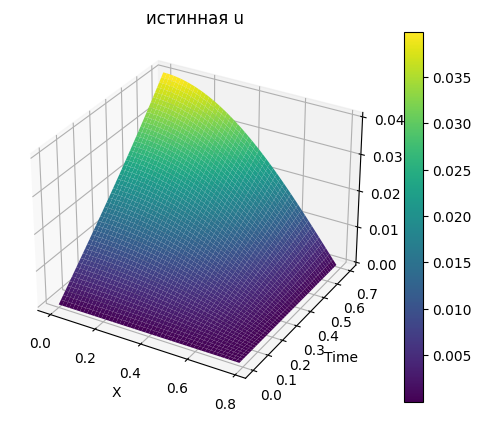

In [ ]:
x_mesh, t_mesh = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_mesh, t_mesh, np.array(find_true(x,y,t)[-2]), cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.set_title('истинная u')
fig.colorbar(surf)

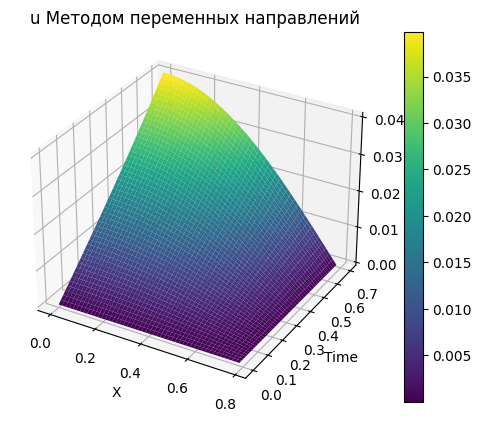

In [ ]:
x_mesh, t_mesh = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_mesh, t_mesh, np.array(perem_naprav(x,y,t)[-2]), cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.set_title('u Методом переменных направлений')
fig.colorbar(surf)

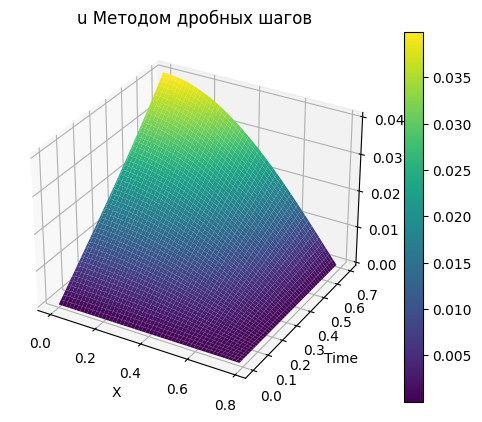

In [ ]:
x_mesh, t_mesh = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_mesh, t_mesh, np.array(drob_shag(x,y,t)[-2]), cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Time')
ax.set_zlabel('Value')
ax.set_title('u Методом дробных шагов')
fig.colorbar(surf)

In [ ]:
def error(x,y,t):

  U_have = perem_naprav(x,y,t)[1:-1]
  U_analytic = find_true(x,y,t)[1:-1]
  # Шаг 3: Вычисление Гауссовой нормы отклонения
  difference = abs(U_have - U_analytic)
  l2_norm = np.linalg.norm(difference) / np.sqrt(np.size(difference))

  return l2_norm


In [ ]:
Nx = [40,50,70,90,110]
hx = []

nx_errors = []


for nx in range(len(Nx)):
  x = np.linspace(0, l, Nx[nx]) #начало, конец, кол-во
  hx.append(abs(x[1] - x[0]))
  y = np.linspace(0, math.log(2), Nx[nx])
  t = np.linspace(0, 1, 300 * 2)
  nx_errors.append(error(x,y,t))


In [ ]:
from scipy.interpolate import PchipInterpolator
nx_errors_ = np.array(nx_errors)*1.483

def plot_func(X, Y, argument, name):
  Y_reverse = np.array(Y)
  X_reverse = np.array(X)

  pchip_reverse = PchipInterpolator(X_reverse, Y_reverse)

  xnew_reverse = np.linspace(min(X_reverse), max(X_reverse), 1000)
  ynew_reverse = pchip_reverse(xnew_reverse)

  plt.figure(figsize=(10, 6))

  plt.scatter(X_reverse, Y_reverse, c='blue', label=name, zorder=6)

  plt.plot(xnew_reverse, ynew_reverse, label='', linewidth=2)

  plt.title('График погрешности')
  plt.xlabel(argument)
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)
  plt.show()


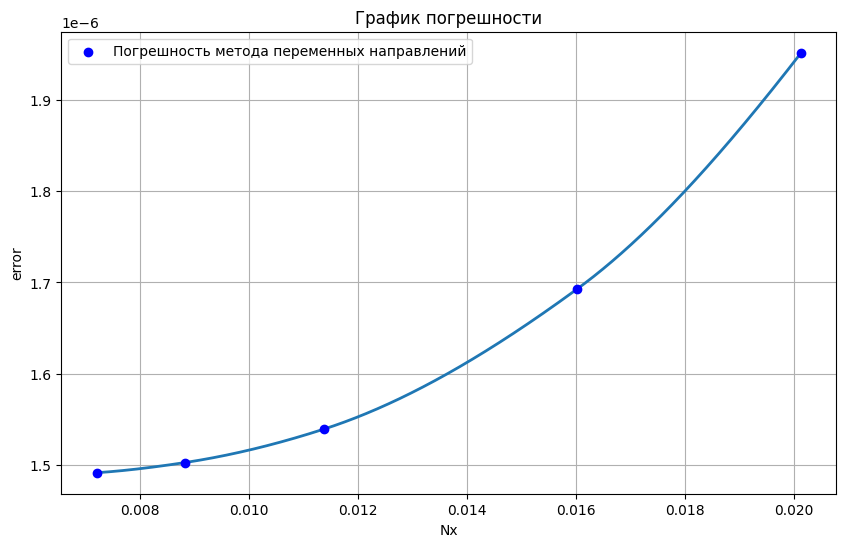

In [ ]:
plot_func(hx[::-1], nx_errors[::-1],'Nx', 'Погрешность метода переменных направлений')

In [ ]:
def _error(x,y,t):

  U_have = drob_shag(x,y,t)[1:-1]
  U_analytic = find_true(x,y,t)[1:-1]
  # Шаг 3: Вычисление Гауссовой нормы отклонения
  difference = abs(U_have - U_analytic)
  l2_norm = np.linalg.norm(difference) / np.sqrt(np.size(difference))

  return l2_norm

Nx_ = [40,50,70,90,110]
hx_ = []

nx_errors_ = []


for nx in range(len(Nx)):
  x_ = np.linspace(0, l, Nx_[nx]) #начало, конец, кол-во
  hx_.append(abs(x_[1] - x_[0]))
  y_ = np.linspace(0, math.log(2), Nx[nx])
  t_ = np.linspace(0, 1, 300 * 2)
  nx_errors_.append(_error(x,y_,t_))



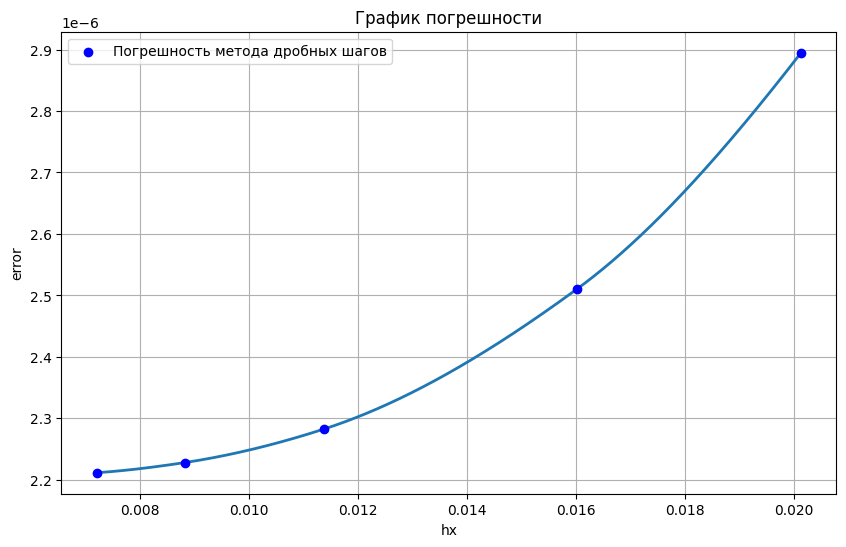

In [ ]:
plot_func(hx[::-1], nx_errors_[::-1],'hx', 'Погрешность метода дробных шагов')